# **Assignment 8 - Computer Vision**

![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

## **Face Mask Prediction using U-Net**
Task is to predict the mask around the face in a given image.

# **Code**

### Making Imports here

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import cv2
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Reshape, ZeroPadding2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import random 
random.seed(0)

### Mount Google drive if you are using google colab
- Mounted my own Gdrive and hosted the different datasets and models there as shortcuts (based on existing links shared)



In [2]:
#### mounting google drive ####
from google.colab import drive
drive.mount("/content/drive/")
folder_path = ("/content/drive/My Drive/Data/")  ##this path is specific to my drive; you will need to configure yours

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load the "images.npy" file (2 marks)
1. Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
2. Data file name: images.npy
3. located at /content/drive/My Drive/Data/images.npy in my GDRIVE

In [3]:
imagesdata = np.load(folder_path + "images.npy",allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Showing the images, the data and the shape of the structures

In [4]:
print(imagesdata.shape)
print(imagesdata[1][0])
print(imagesdata[1][1])
print(imagesdata[1][0].shape)

(409, 2)
[[[207 216 227 255]
  [206 216 227 255]
  [207 216 227 255]
  ...
  [ 35  33  34 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 [[207 216 227 255]
  [207 216 227 255]
  [207 216 227 255]
  ...
  [ 35  32  33 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 [[207 216 227 255]
  [207 216 227 255]
  [207 215 227 255]
  ...
  [ 35  33  33 255]
  [ 35  33  34 255]
  [ 35  33  34 255]]

 ...

 [[ 31  21  17 255]
  [ 31  22  18 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]

 [[ 31  22  18 255]
  [ 31  22  18 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]

 [[ 31  22  18 255]
  [ 30  22  17 255]
  [ 31  22  18 255]
  ...
  [  0   1   4 255]
  [  0   1   4 255]
  [  0   1   4 255]]]
[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527}, {'x': 0.7692307692307693, 'y': 0.36182902584493043}], 'imageWidth': 1280, 'imageHeight': 697}]
(697, 1280, 4)


#### Showing the image and the bounded boxes (please note that there is a nested structure for the bounding boxes. In this case, we have accessed an image with only one bounding box, hence the code works. In case of an image with multiple bounding boxes, we would need to write the code for iteration through the data structure as well)

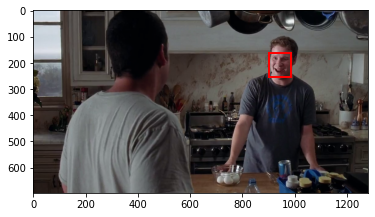

In [5]:
fig, ax = plt.subplots(1) 
ax.imshow(imagesdata[1][0])
x0 = imagesdata[1][1][0]["points"][0]["x"] * imagesdata[1][1][0]["imageWidth"]
y0 = imagesdata[1][1][0]["points"][0]["y"] * imagesdata[1][1][0]["imageHeight"]
x1 = imagesdata[1][1][0]["points"][1]["x"] * imagesdata[1][1][0]["imageWidth"]
y1 = imagesdata[1][1][0]["points"][1]["y"] * imagesdata[1][1][0]["imageHeight"]
rect = patches.Rectangle((x0 ,y0), x1 - x0, y1 - y0, linewidth = 2, edgecolor = "r", facecolor = "none")
ax.add_patch(rect)
plt.show()

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 
- Unlike our training lectures, the output here is in 224*224 format, so we are setting everything to 224

In [6]:
ALPHA = 1.0
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = 224

HEIGHT_CELLS = 224
WIDTH_CELLS = 224

### Create features and labels (PREWRITTEN CODE)
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [7]:
##commented imports as they are already done
##import cv2
##from tensorflow.keras.applications.mobilenet import preprocess_input

## creating a mask of the size 224, 224. initially values are set to 0 for all pixels
masks = np.zeros((int(imagesdata.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
## Initializing array for storing X(images) 
x = np.zeros((int(imagesdata.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(imagesdata.shape[0]):
    img = imagesdata[index][0]
    ## resizing the image
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    ## storing the images here
    x[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in imagesdata[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        ## setting the slice which is boxed by the points as all ones. This is the area that will be be unaffected
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing (2 marks)
- 400 images in training ( We further split this into train and val)
- 9 images in testing data

**Creating the Training and Testing data**

  We shuffle the indices and then use them to create data. 
  There are 3 sets of data created. Train, Val and Test
  Masks is used to create the y_train, y_val, y_test
  x is used to create x_train, x_val, x_test

In [8]:
indices = np.random.permutation(imagesdata.shape[0]) ##creating a random permutation of the array indices
train_idx, val_idx, test_idx = indices[:380], indices[380:400], indices[400:] #breaking up the indices generated
x_train, x_val, x_test = x[train_idx,:], x[val_idx,:], x[test_idx,:] #using indices to create train and test sets
print (x_train.shape)
print (x_val.shape)
print (x_test.shape)
y_train, y_val, y_test = masks[train_idx,:], masks[val_idx,:], masks[test_idx,:]#using indices to create train and test sets
print (y_train.shape)
print (y_val.shape)
print (y_test.shape)

(380, 224, 224, 3)
(20, 224, 224, 3)
(9, 224, 224, 3)
(380, 224, 224)
(20, 224, 224)
(9, 224, 224)


### Print a sample training image, image array and its mask (2 marks)

Sample training image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


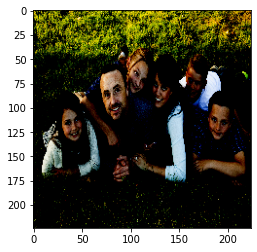

In [9]:
fig, ax = plt.subplots(1) 
ax.imshow(x_train[1])
plt.show()

Print the image array

In [10]:
print(x_train[1])

[[[ 0.7019608   0.66274512 -1.        ]
  [ 0.66274512  0.63921571 -0.70980394]
  [ 0.05098045  0.02745104 -0.78823531]
  ...
  [ 0.87450981  0.6156863  -0.12941176]
  [ 0.49803925  0.24705887 -0.32549018]
  [ 0.88235295  0.75686276 -0.29411763]]

 [[ 0.62352943  0.56862748 -0.79607844]
  [ 0.84313726  0.70980394 -0.5529412 ]
  [ 0.29411769  0.22352946 -0.75686276]
  ...
  [ 0.84313726  0.56862748 -0.06666666]
  [ 0.56078434  0.34901965 -0.25490195]
  [ 0.63921571  0.44313729 -0.30196077]]

 [[ 0.79607844  0.68627453 -0.74117649]
  [ 0.54509807  0.54509807 -1.        ]
  [ 0.81960785  0.79607844 -0.50588238]
  ...
  [ 0.57647061  0.41176474 -0.26274508]
  [ 0.24705887  0.082353   -0.33333331]
  [ 0.23921573  0.00392163 -0.36470586]]

 ...

 [[-0.73333335 -0.72549021 -0.8509804 ]
  [-0.59215689 -0.49803919 -0.80392158]
  [-0.65490198 -0.64705884 -1.        ]
  ...
  [-0.80392158 -0.79607844 -0.9137255 ]
  [-0.63137257 -0.5529412  -0.96862745]
  [-0.70980394 -0.64705884 -0.97647059]]

 [

Printing the Mask

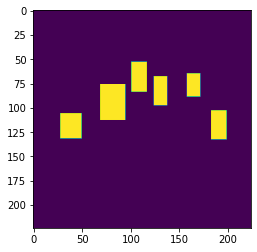

In [11]:
fig, ax = plt.subplots(1) 
ax.imshow(y_train[1])
plt.show()

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

#### **We want accuracy to be high, so we will concatenate the layers with the earlier mobilenet layers as well**

In [12]:
def create_model(trainable=True):
  model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

  for layer in model.layers:
    layer.trainable = trainable
  ## We retain last 4 layers as trainable to increase accuracy
  model.get_layer("conv_pw_10_relu").trainable = True
  model.get_layer("conv_pw_11_relu").trainable = True
  model.get_layer("conv_pw_12_relu").trainable = True
  model.get_layer("conv_pw_13_relu").trainable = True
  
  ## we want features from multiple levels so we are taking concats at 112*112, 28*28, 14*14 
  block1 = model.get_layer("conv_pw_1_relu").output
  block2 = model.get_layer("conv_pw_5_relu").output
  block3 = model.get_layer("conv_pw_11_relu").output
  block4 = model.get_layer("conv_pw_13_relu").output
  
  x = Concatenate()([UpSampling2D()(block4), block3]) #14*14
  x = Conv2D(128, kernel_size=1, activation="relu")(x)##reducing the number of filters to a manageable level
  x = Concatenate()([UpSampling2D()(x), block2]) #28*28
  x = Conv2D(128, kernel_size=1, activation="relu")(x)##reducing the number of filters to a manageable level
  x = UpSampling2D()(x) #56*56
  x = Concatenate()([UpSampling2D()(x), block1]) #112*112
  x = Conv2D(128, kernel_size=1, activation="relu")(x)##reducing the number of filters to a manageable level
  x = UpSampling2D()(x)
  ## the final activation is applied to an output 224*224. This helps us be close to the actual face.
  x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
  ## Reshaping to 224*224
  x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x) 


  return Model(inputs = model.input, outputs = x)


## Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [13]:
model = create_model(False)

## Print model summary (1 mark)

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

## Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


In [15]:
def dice_coeff(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true * y_pred)

  return numerator/(denominator + (0.00001))

## Define loss function (2 marks)
- We use binary_crossentropy as a measure of loss 

In [16]:
def loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coeff(y_true, y_pred) + tf.keras.backend.epsilon())

## Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [17]:
optimizer = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad=False)
model.compile(loss = loss, optimizer = optimizer, metrics = [dice_coeff])

## Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [18]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor = "val_loss", verbose = 1, save_best_only = True, save_weights_only = True)
stop = EarlyStopping (monitor = "val_loss", patience = 3) #keeping patience as 3, waiting for neural networks is painful
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, patience = 3, min_lr = 1e-7, verbose = 1) #factor tweaked to 0.3 and patience to 3 to increase aggression in learning rate change

## Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [19]:
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 5, batch_size = 1, verbose = 1, callbacks = [checkpoint, stop, reduce_lr])

Epoch 1/5
380/380 [==============================] - ETA: 0s - loss: -0.3673 - dice_coeff: 1.9947
Epoch 00001: val_loss improved from inf to -0.46491, saving model to model--0.46.h5
380/380 [==============================] - 66s 173ms/step - loss: -0.3673 - dice_coeff: 1.9947 - val_loss: -0.4649 - val_dice_coeff: 2.0000
Epoch 2/5
380/380 [==============================] - ETA: 0s - loss: -0.4572 - dice_coeff: 1.9947
Epoch 00002: val_loss improved from -0.46491 to -0.48765, saving model to model--0.49.h5
380/380 [==============================] - 66s 173ms/step - loss: -0.4572 - dice_coeff: 1.9947 - val_loss: -0.4876 - val_dice_coeff: 2.0000
Epoch 3/5
380/380 [==============================] - ETA: 0s - loss: -0.4723 - dice_coeff: 1.9947
Epoch 00003: val_loss did not improve from -0.48765
380/380 [==============================] - 66s 173ms/step - loss: -0.4723 - dice_coeff: 1.9947 - val_loss: -0.4754 - val_dice_coeff: 2.0000
Epoch 4/5
380/380 [==============================] - ETA: 0s 

## Get the predicted mask for a test image   (2 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


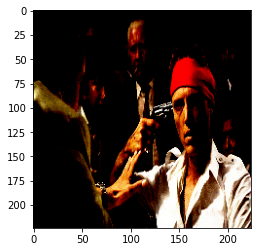

In [20]:
unscaled = x_test[3]
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
plt.imshow(image)

Show original mask for test image

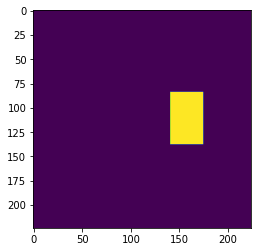

In [21]:
plt.imshow(y_test[3])

Predict the mask on the test image

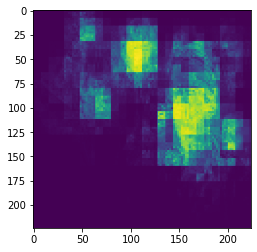

In [22]:
pred_mask = model.predict(x = np.array([image]))
pred_mask = pred_mask.reshape(224,224)
#pred_mask = 1.0 * (pred_mask > 0.6) Can use this for a rough binarization
plt.imshow(pred_mask)

## Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


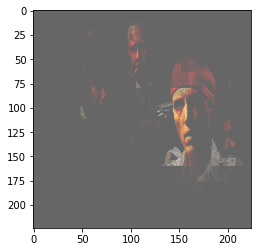

In [23]:
image2 = image
image2[:,:,0] = pred_mask * image[:,:,0]
image2[:,:,1] = pred_mask * image[:,:,1]
image2[:,:,2] = pred_mask * image[:,:,2]
plt.imshow(image2, alpha = 0.6)

This produces a translucent type image that retains RGBA values but makes the others darker.

**Just for exploration, we try alpha = 1**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


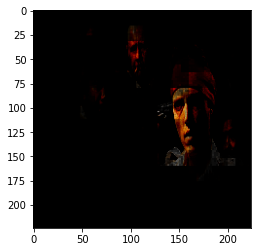

In [24]:
image2 = image
image2[:,:,0] = pred_mask * image[:,:,0]
image2[:,:,1] = pred_mask * image[:,:,1]
image2[:,:,2] = pred_mask * image[:,:,2]
plt.imshow(image2, alpha = 1)

This makes the image look sharper 

**Our approach in video lectures uses the mask itself to derive opacity**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


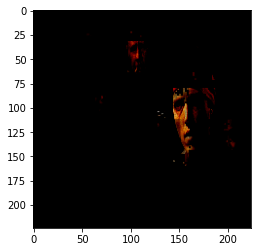

In [26]:
image2 = image
pred_mask = 1.0 * (pred_mask > 0.5) ##appending the alpha in mask itself
image2[:,:,0] = pred_mask * image[:,:,0]
image2[:,:,1] = pred_mask * image[:,:,1]
image2[:,:,2] = pred_mask * image[:,:,2]
plt.imshow(image2)

**Our evolved model is able to discover additional faces that were not originally tagged.** 

# **Assignment End**